In [ ]:
import copy
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models, transforms

In [ ]:
def load_image(img, size):
    image = img.convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(size), # Resize image to have the same spatial resolution between style and content
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :]), # Drop alpha channel if exists
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet z-score normalization
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(torch.float)

def reverse_norm(tensor):
    tensor = tensor.clone().squeeze(0)
    device = tensor.device

    tensor = tensor * torch.tensor([0.229, 0.224, 0.225], device=device).view(3,1,1) # Inverse normalization for visualization
    tensor = tensor + torch.tensor([0.485, 0.456, 0.406], device=device).view(3,1,1)
    tensor = tensor.clamp(0, 1) # Security because outputs of our NN are not guaranteed to be restricted to valid pixel ranges
    return transforms.ToPILImage()(tensor.cpu())


In [ ]:
class VGGFeatures(nn.Module):
    def __init__(self, layers=None):
        super().__init__()
        self.vgg = models.vgg19(weights='DEFAULT').features.eval() # Extract pre-trained convolutional layers and disable training
        self.layers = {'0': 'conv1_1',
                                '5': 'conv2_1', # style
                                '10': 'conv3_1', # style
                                '19': 'conv4_1', # style
                                '21': 'conv4_2', # content
                                '28': 'conv5_1'} # style

    def forward(self, x):
        features = {}
        for idx, layer in self.vgg._modules.items():
            x = layer(x) # Pass through each layers
            if idx in self.layers:
                features[self.layers[idx]] = x # Store the output feature
        return features

In [ ]:
model = VGGFeatures()
model.vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    G = torch.mm(tensor, tensor.t())
    return G / (c * h * w) # Normalize gram matrix for inter-layer comparison

def style_loss(target_features, style_features):
    loss = 0
    for layer in style_features:
        G = gram_matrix(target_features[layer])
        A = gram_matrix(style_features[layer])
        loss += torch.mean((G - A)**2) # MSE between gram matrix
    return loss

def content_loss(target_features, content_features):
    return torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # MSE between content layers

In [ ]:
def style_transfer(content_img, style_img, steps, style_weight=1e4, content_weight=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    content = load_image(content_img, 512).to(device)
    style = load_image(style_img, 512).to(device)

    vgg = VGGFeatures().to(device).eval() # Disable training for the wrapper
    content_features = vgg(content)
    style_features = vgg(style)

    target = content.clone().requires_grad_(True).to(device) # Initiate the generated image with a copy of the content image
    optimizer = optim.LBFGS([target]) # Optimize pixels pf the target image

    step = [0]
    while step[0] <= steps:
        def closure(): # Closure to support LBFGS algorithm
            optimizer.zero_grad()
            target_features = vgg(target)

            c_loss = content_loss(target_features, content_features)
            s_loss = style_loss(target_features, style_features)
            loss = content_weight * c_loss + style_weight * s_loss

            loss.backward(retain_graph=True)
            step[0] += 1

            return loss

        optimizer.step(closure)

    return target

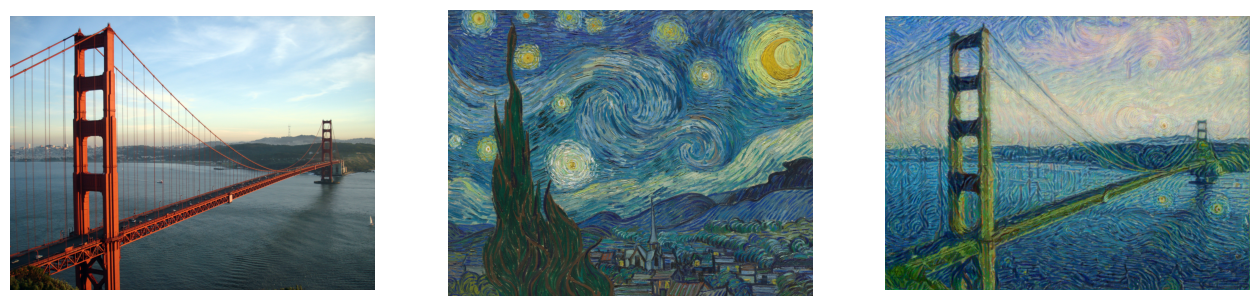

In [ ]:
content_img = Image.open("bridge.jpg")
style_img = Image.open("vangogh.jpg")
output = style_transfer(content_img, style_img, 300, 1e12, 1)
result_image = reverse_norm(output)

plt.figure(figsize=(16, 4))
for i, img in enumerate([content_img, style_img, result_image]):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.show()